# Study of the results of the VAE for the duck

In this notebook we study the results of the VAE trained on the COIL's duck dataset.
This are the things we do :
   1. We look at the output of the VAE given testing data,
   2. We try to predict one modality (PI or density) given only the other one,
   3. We study the latent distribution
   4. We draw a random $z_{joint}$ and passe it throw the decoder to see the output
   5. We try to generate new ducks

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from time import time

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy.stats import multivariate_normal

import imageio

import gudhi as gd
import gudhi.representations

from tqdm import tqdm

### We strat by loading the VAE

In [18]:
vae = tf.keras.models.load_model('../Trained_VAE/VAE_full_duck/')
vae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_PI (Encoder_PI)      multiple                  255354    
_________________________________________________________________
decoder_PI (Decoder_PI)      multiple                  252800    
_________________________________________________________________
sampling_2 (Sampling)        multiple                  0         
_________________________________________________________________
decoder_PC (Shared_Decoder)  multiple                  354       
_________________________________________________________________
encoder_image (Encoder_image multiple                  1638904   
_________________________________________________________________
decoder_image (Decoder_image multiple                  1660034   
Total params: 3,807,446
Trainable params: 3,807,446
Non-trainable params: 0
_____________________________________________

We then load the data and compute the PIs

In [19]:
images_duck = np.zeros((72, 128, 128))
for i in range(72):
    images_duck[i] = np.array(imageio.imread("../Datasets/COILs_duck/obj1__" +
                                        str(i) + ".png"),
                         dtype=float)
images_duck /= 255.

In [20]:
PI_size = 50
PI_duck = np.zeros((72, PI_size * PI_size))
PI = gd.representations.PersistenceImage(bandwidth=7e-2,
                                         weight=lambda x: x[1]**2,
                                         resolution=[50, 50],
                                         im_range=[0, 1, 0, 1])
images_duck_flat = np.zeros((72, 128* 128))

for i in tqdm(range(72)):
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=images_duck[i])
    cubical_complex.compute_persistence()
    pi = PI.fit_transform(
        [cubical_complex.persistence_intervals_in_dimension(1)])
    PI_duck[i] = pi[0]
    images_duck_flat[i] = images_duck[i].flatten()
    #gd.plot_persistence_diagram(cubical_complex.persistence())
PI_duck/=np.max(PI_duck)

100%|███████████████████████████████████████████| 72/72 [00:09<00:00,  7.96it/s]


In [21]:
images_duck = images_duck_flat 

### Study of the output given a input the VAE hasn't seen

This are the true images and PI

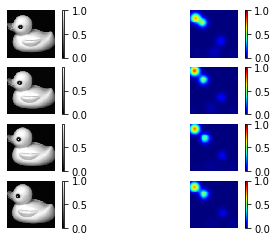

In [22]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.reshape(images_duck[i], [128, 128]),
               cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(4, 2, 2 * i + 2)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.flip(np.reshape(PI_duck[i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    plt.axis('off')

We give them to the VAE

In [13]:
PI_pred, images_pred = vae((PI_duck, images_duck))

2021-07-28 09:22:40.088502: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 09:22:40.155035: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


This are the output of the VAE

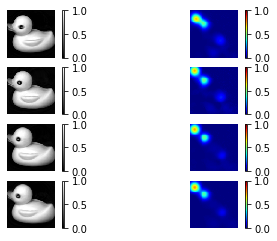

In [14]:
j = 0
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.reshape(images_pred[i+ j], [128, 128]),
               vmin=0,
               vmax=1,
               cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(PI_pred[i + j], [PI_size, PI_size]), 0), cmap='jet',vmin=0,vmax=1)
    plt.colorbar()
    plt.axis('off')

### Try to predict a couple of (PI,density) given only one of the two modalities

#### Predict a image from a PI

To do this we give the PIs encoder the PIs

In [19]:
z_mean_PI, z_var_PI = vae.encoder_PI(PI_duck)

From the $(\mu_{PI},\sigma_{PI})$ we get from the PIs encoder we can compute $(\mu_{joint},\sigma_{joint})$

In [20]:
mean_joint = (z_mean_PI / z_var_PI) * (1 + 1 / z_var_PI)
var_joint = (1 + 1 / z_var_PI)

We then sample $z_{joint}$ from $\mathcal N(\mu_{joint},\sigma_{joint})$

In [21]:
z_joint = vae.sampling((mean_joint, var_joint))

We can then decode $z_{joint}$ to a couple of (PI,image)

In [23]:
z_PI, z_image = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_image = vae.decoder_image(z_image)

We can plot them

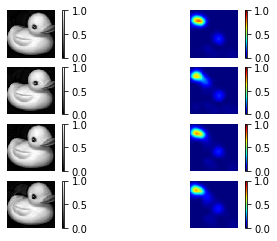

In [25]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.reshape(reconstructed_image[i], [128, 128]),
               vmin=0,
               vmax=1,
               cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PI[i], [PI_size, PI_size]), 0), cmap='jet',vmin=0,vmax=1)
    plt.colorbar()
    plt.axis('off')
#plt.savefig("Résultats/VAE_full_2_predict_density_from_PI.pdf")

#### Predict a PI from a image 

Here we do the same thing but with a image at the start : we give the images encoder the densities

In [27]:
z_mean_image, z_var_image = vae.encoder_image(images_duck)

From the $(\mu_{image},\sigma_{image})$ we get from the images encoder we can compute $(\mu_{joint},\sigma_{joint})$

In [28]:
mean_joint = (z_mean_image / z_var_image) * (1 + 1 / z_var_image)
var_joint = (1 + 1 / z_var_image)

We then sample $z_{joint}$ from $\mathcal N(\mu_{joint},\sigma_{joint})$

In [29]:
z_joint = vae.sampling((mean_joint, var_joint))

We can then decode $z_{joint}$ to a couple of (PI,image)

In [30]:
z_PI, z_image = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_image = vae.decoder_image(z_image)

We plot them

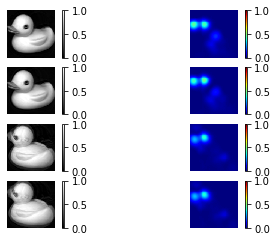

In [31]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.reshape(reconstructed_image[i], [128, 128]),
               vmin=0,
               vmax=1,
               cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PI[i], [PI_size, PI_size]), 0), cmap='jet',vmin=0,vmax=1)
    plt.colorbar()
    plt.axis('off')

### Study of the latent distribution 

To study the latent distribution we compute the $(\mu_{joint},\sigma_{joint})$ for each position of the duck on the data.

We can then encode these into a `multivariate_normal` object and then plot the gaussian in 3D or in 2D.

In [23]:
z_mean_PI, z_var_PI = vae.encoder_PI(PI_duck)
z_mean_image, z_var_image = vae.encoder_image(images_duck)

mean_joint = (z_mean_PI / z_var_PI +
              z_mean_image / z_var_image) * (1 + 1 / z_var_PI + 1 / z_var_image)
var_joint = (1 + 1 / z_var_PI + 1 / z_var_image)

In [26]:
M = 200
X, Y = np.meshgrid(np.linspace(-10, 10, M), np.linspace(-10, 10, M))
d = np.dstack([X, Y])

gauss = []
Z = []

for i in range(len(mean_joint)):
    gauss.append(multivariate_normal(mean=mean_joint[i], cov=np.abs(var_joint[i])))

    Z.append(gauss[i].pdf(d).reshape(M, M))

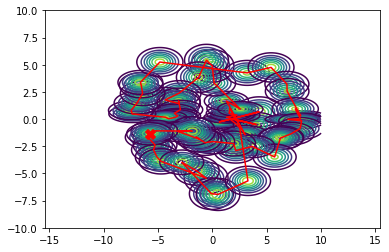

In [27]:
from matplotlib import cm

plt.figure()
#my_col = [
#    "red", "peru", "olive", "darkorange", "yellow", "greenyellow",
#    "mediumspringgreen", "turquoise", "dodgerblue", "blueviolet"
#]

contour = []
legend = []
for i in range(len(mean_joint)):
    plt.contour(X, Y, Z[i],extend='min')
    #h, _ = contour[i].legend_elements()
    #legend.append(h[0])
    plt.axis("equal")
    #plt.xlim(-25,25)
    #plt.ylim(-25,25)
plt.plot(mean_joint[:,0],mean_joint[:,1],color='red')
plt.scatter(mean_joint[-1,0],mean_joint[-1,1],s=100,c="red",marker="X",zorder=2)

In [49]:
fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig)

for i in range(len(mean_joint)):
    ax.plot_surface(X, Y, Z[-i], rstride=1, cstride=1, cmap='RdPu')
#carre = ax.plot_surface(X,
#                        Y,
#                        Z_1,
#                        rstride=1,
#                        cstride=1,
#                        alpha=0.8,
#                        cmap='seismic')
#cercle = ax.plot_surface(X,
#                         Y,
#                         Z_2,
#                         rstride=1,
#                         cstride=1,
#                         alpha=0.8,
#                         cmap='jet')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_xlim(-5, 5)
#ax.set_ylim(-5, 5)

#cbar1 = plt.colorbar(carre, location='bottom', shrink=0.5, pad=0.001)
#cbar2 = plt.colorbar(cercle,
#                     label='Latent distribution of the circle',
#                     location='bottom',
#                     shrink=0.5,
#                     pad=0.001)
#cbar1.set_label('Latent distribution of the square', size=18)
#cbar2.set_label('Latent distribution of the circle', size=18)

plt.title('3D representation of the latent distribution', size=18)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9208b8d550> (for post_execute):


KeyboardInterrupt: 

### Generate random $z_{joint}$

We try to generate a random $z_{joint}$ from $\mathcal N(0,\begin{pmatrix}25&0\\0&25\end{pmatrix})$. We then decode this random $z_{joint}$ and plot the PI and density we get from it.

In [90]:
z_joint = np.random.normal(size=(4,2),scale=[25,25])
z_PI, z_image = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_image = vae.decoder_image(z_image)

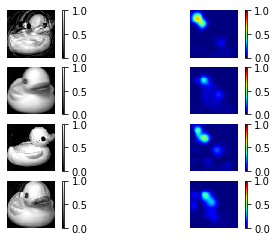

In [91]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.reshape(reconstructed_image[i], [128, 128]),
               vmin=0,
               vmax=1,
               cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PI[i], [PI_size, PI_size]), 0), cmap='jet',vmin=0,vmax=1)
    plt.colorbar()
    plt.axis('off')

### Try to create new duck

We try to create new positions of the duck by sampling a $z_{joint}$ between each kwnon position. We take the $z_{joint}$ is the middle of two consecutive gaussians representing two consecutive positions of the duck.

We then decode those $z_{joint}$ and plot the result.

In [3]:
PI_size=50
size=50

In [82]:
z_joint = []
for i in range(len(mean_joint)-1):
    z_joint.append(mean_joint[i])
    z_joint.append((mean_joint[i] + mean_joint[i+1])/2)

In [84]:
z_PI, z_image = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_image = vae.decoder_image(z_image)

/tmp/ipykernel_7605/708130959.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4, 8))


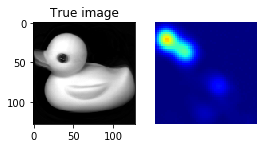

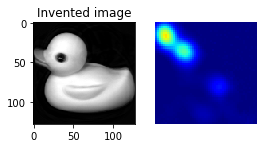

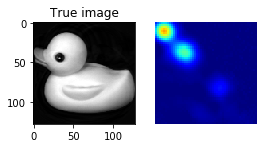

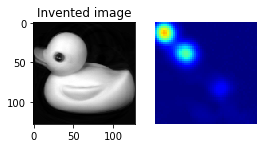

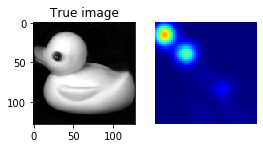

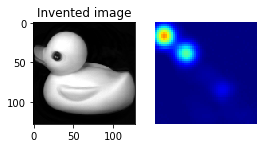

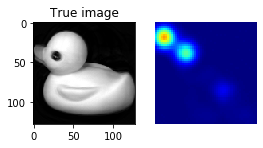

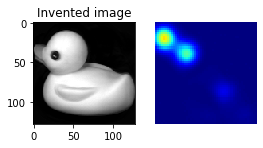

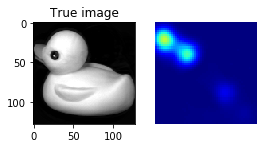

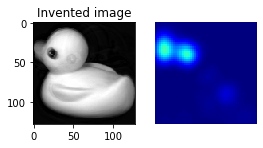

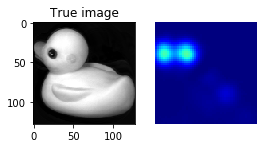

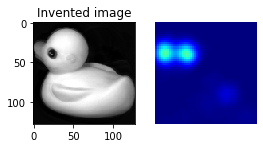

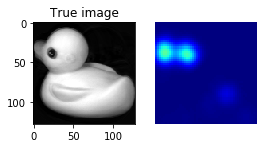

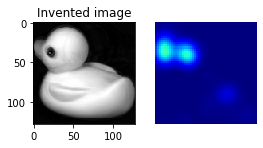

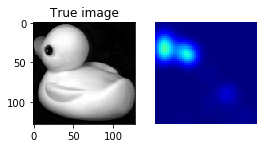

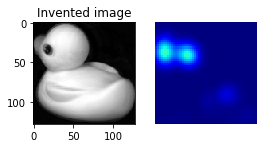

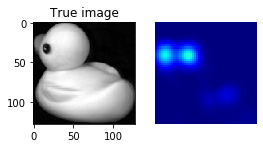

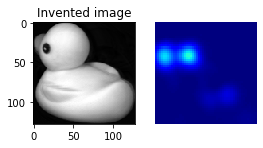

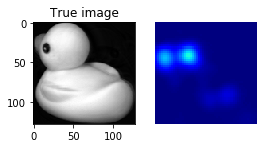

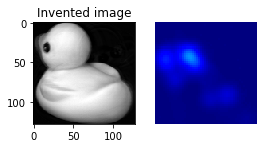

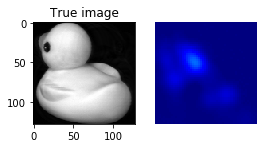

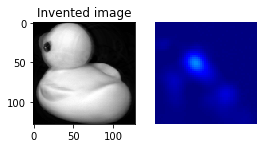

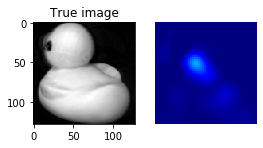

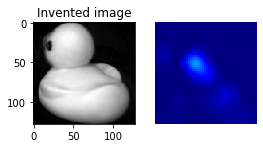

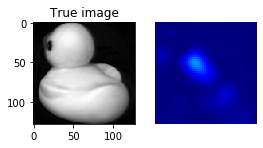

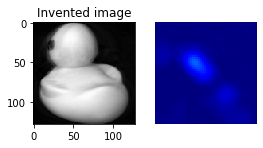

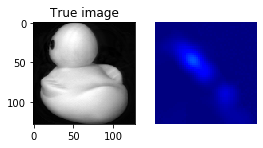

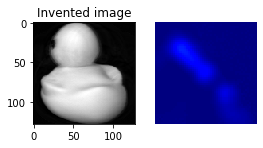

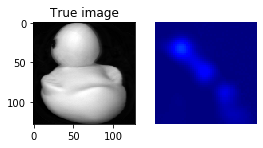

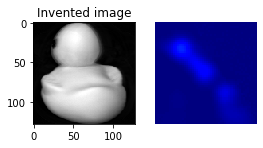

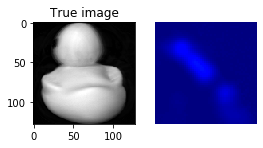

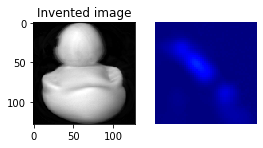

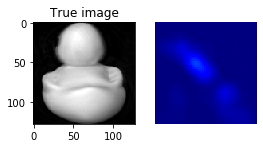

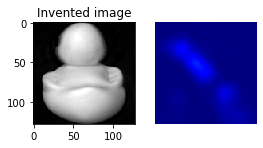

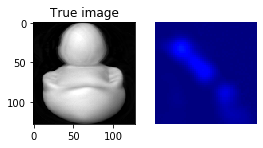

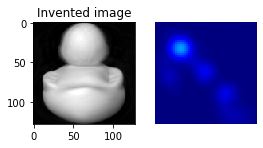

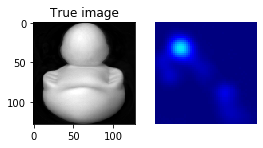

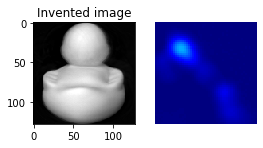

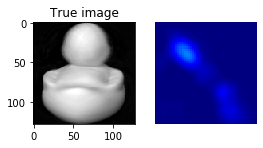

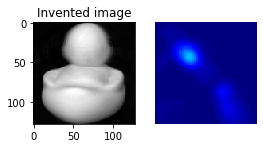

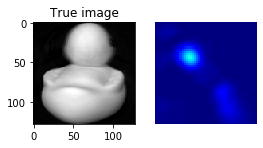

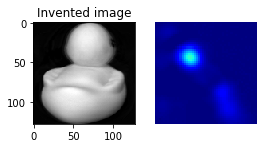

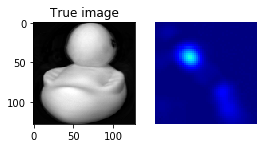

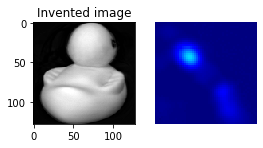

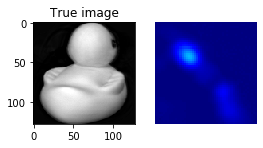

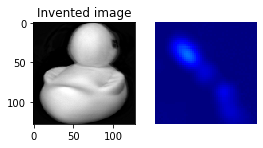

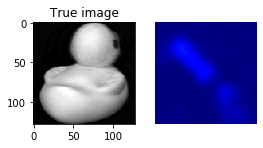

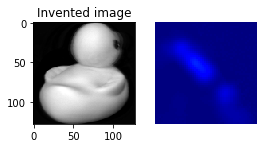

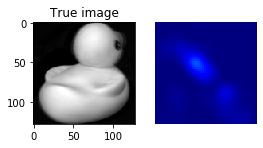

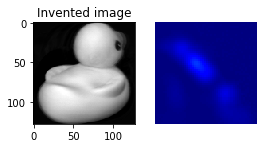

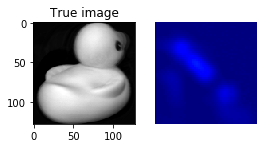

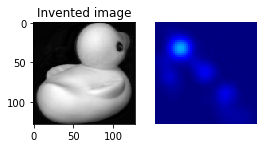

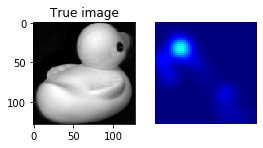

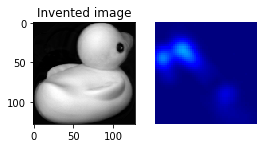

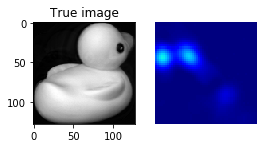

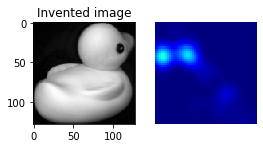

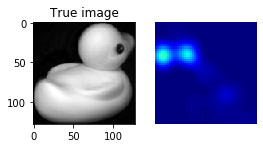

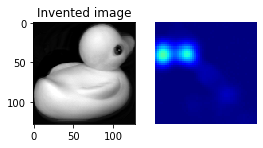

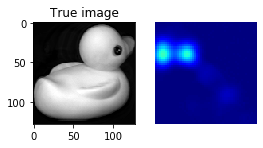

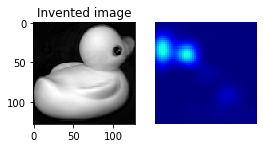

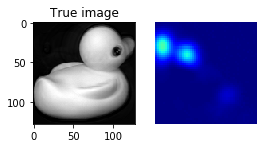

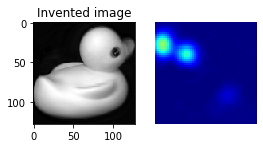

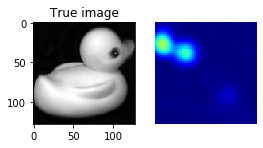

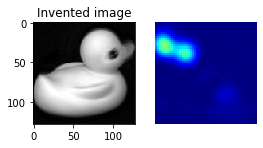

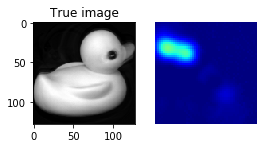

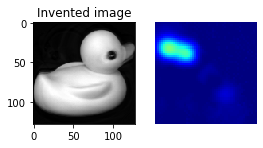

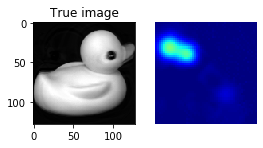

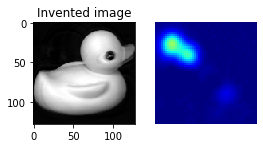

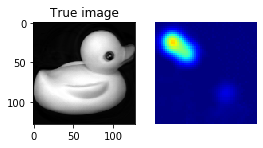

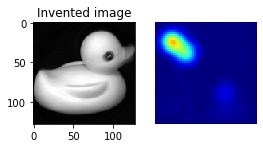

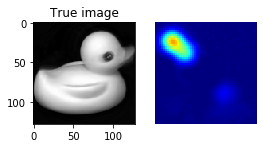

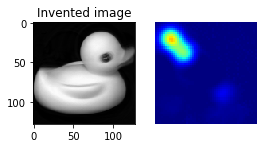

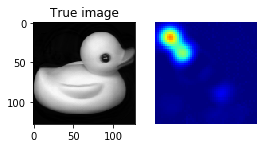

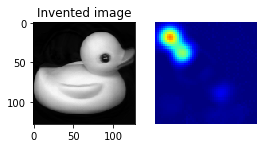

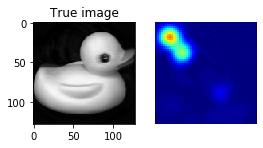

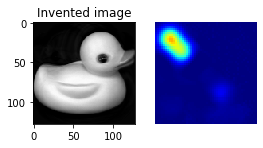

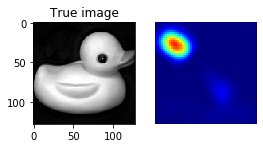

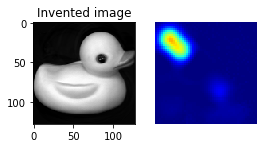

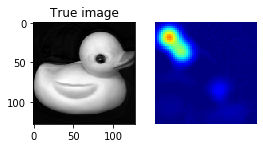

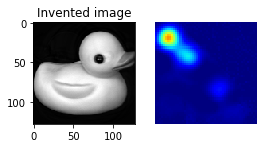

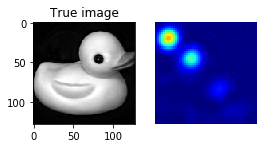

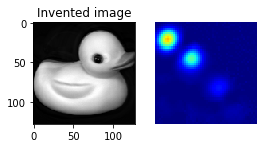

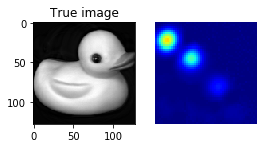

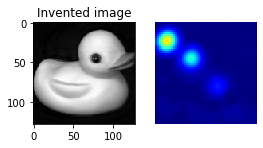

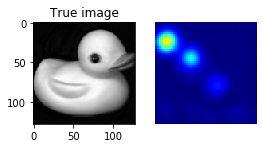

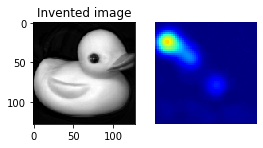

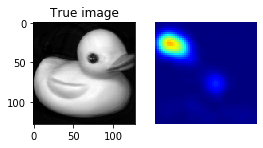

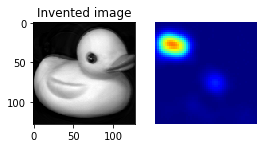

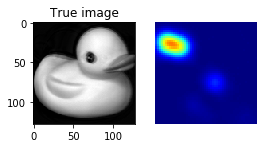

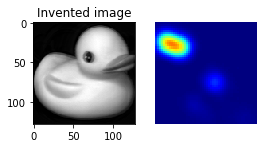

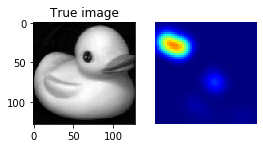

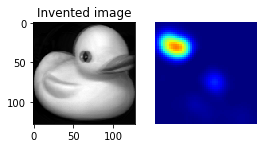

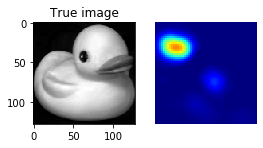

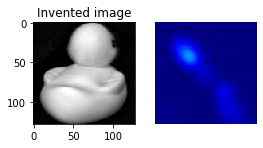

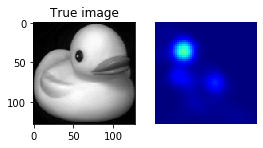

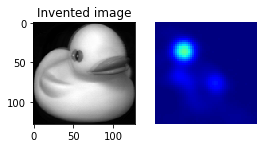

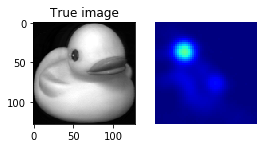

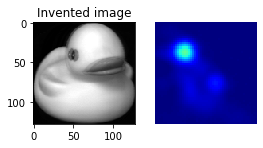

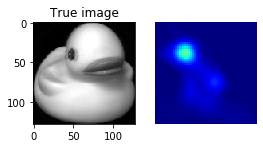

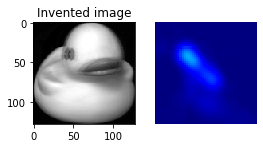

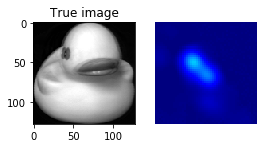

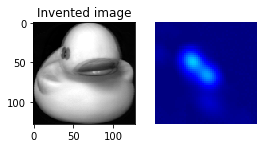

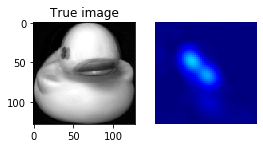

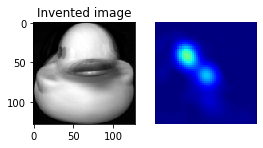

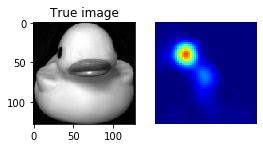

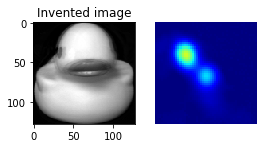

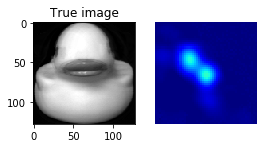

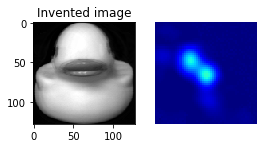

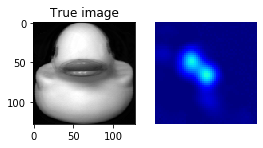

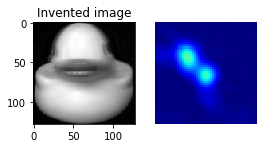

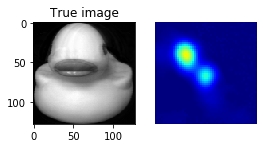

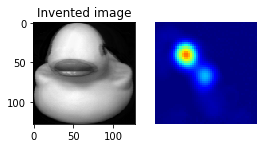

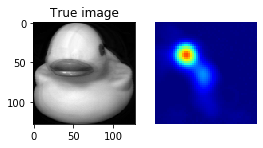

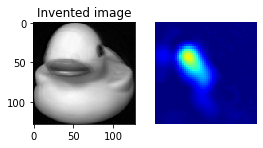

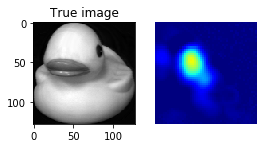

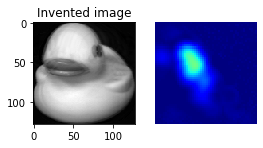

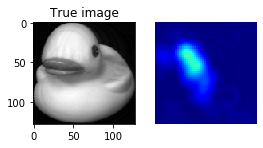

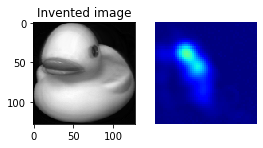

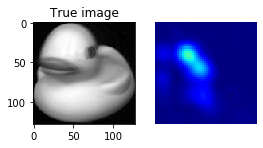

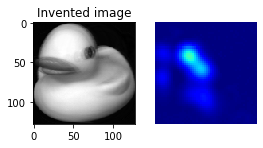

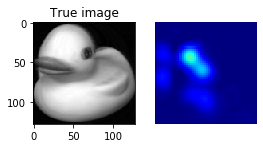

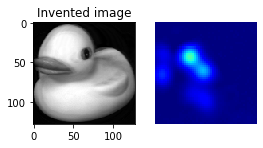

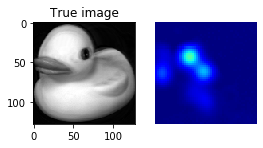

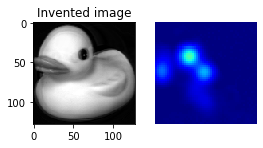

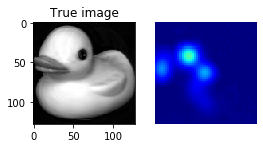

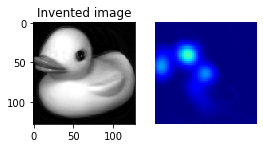

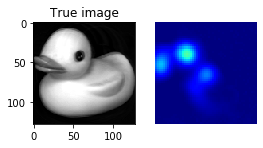

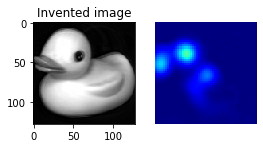

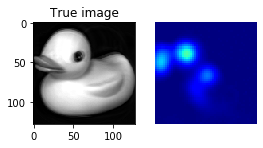

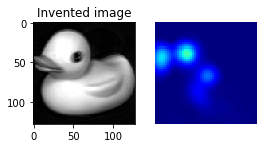

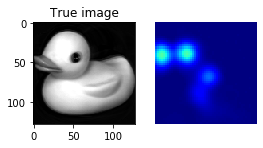

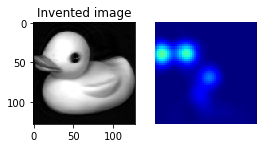

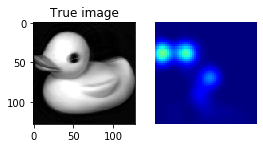

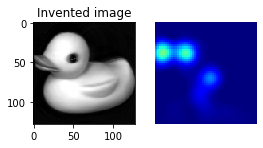

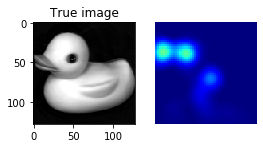

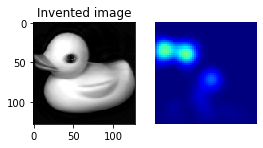

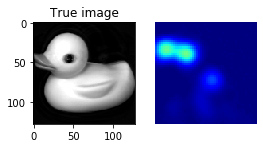

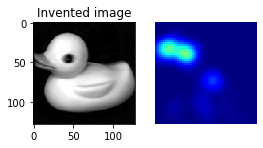

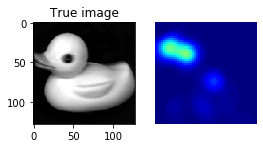

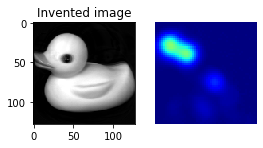

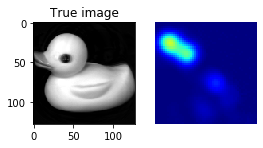

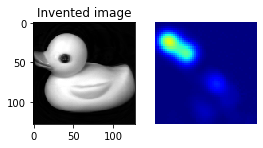

In [89]:
for i in range(len(z_joint)):
    plt.figure(figsize=(4, 8))
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(reconstructed_image[i], [128, 128]),
               vmin=0,
               vmax=1,
               cmap='gist_gray')
    if(i%2 == 0):
        plt.title("True image")
    else:
        plt.title("Invented image")
    #plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PI[i], [PI_size, PI_size]),
                       0),
               vmin=0,
               vmax=1,
               cmap='jet',aspect='equal')
    #plt.colorbar()
    plt.axis('off')

    #plt.savefig("Résultats/from_square_to_circle_"+str(i)+".png")